In [1]:
import dp4gp_datasets as datasets
import dp4gp
import GPy

import pandas as pd
import dp4gp_datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import dp4gp


warning in stationary: failed to import cython module: falling back to numpy


# Citibike Demo

In [ ]:

df = datasets.load_citibike()
datasets.add_citibike_extra_columns(df)

In [ ]:
boundarylist = [('hours',0,24*1,0.5), ('tripduration_mins',0,60.0,20.0)]
output,point_row_form,area_row_form,output_row_form,bins = dp4gp.bin_dataframe(df,boundarylist,verbose=True)

#output_row_form -= np.mean(output_row_form)
#output_row_form /= np.std(output_row_form)
kernel = GPy.kern.Multidimensional_Integral_Limits(input_dim=area_row_form.shape[1],lengthscale=[10.0,1.0],variances=[1.0])
m_int = GPy.models.GPRegression(1.0*area_row_form,1.0*output_row_form[:,None],kernel)
m_int.optimize(messages=True,max_iters=50)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
y = []
x = []
for h in np.arange(0,48,0.1):
    x.append(h)
    res,cov = m_int.predict_noiseless(np.array([[h+0.1,h,0.1,0.0]]))
    y.append(res[0][0])
plt.plot(x,np.array(y)*10) #x10 because step size during training was 0.5 x 20 = 10
plt.plot(area_row_form[area_row_form[:,2]==20,0]-1,output_row_form[area_row_form[:,2]==20])

TO DO: Include GP for DP version

# House price example

In [2]:
complete = datasets.load_prices_and_postcode()

In [3]:
ys = complete['price'].values
#ys = np.log(complete['price'].values)
training_inputs = np.vstack([complete['easting'].values,complete['northing'].values]).T


In [ ]:
#squash data into £200k-£700k range
ys[ys>7e5] = 7e5
ys[ys<2e5] = 2e5
#ys = np.log(ys)
#sens = np.log(7e5)-np.log(2e5)
sens = 7e5-2e5

london_east = 530000
london_north = 180000
size = 100000
samp = (training_inputs[:,0]>london_east-size) & (training_inputs[:,0]<london_east+size) & (training_inputs[:,1]>london_north-size) & (training_inputs[:,1]<london_north+size)
ys = ys[samp]
training_inputs = training_inputs[samp,:]

import random
samp = random.sample(range(1, len(ys)), 5000)
ys = ys[samp]
training_inputs = training_inputs[samp,:]

#use logs
#ys = np.log(ys)

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5).fit(training_inputs) #50 cities, so using about 70 inducing inputs. just london - use 10

centres = kmeans.cluster_centers_
sparse = []
for i, c in enumerate(centres):
    skip = False
    for d in centres[0:i]:
        if (np.sum((d-c)**2)<12000**2):
            skip = True
            break
    if not skip:
        sparse.append(c)
sparse = np.array(sparse)

In [ ]:
test_inputs = []
step = 5000
for easting in np.arange(london_east-size,london_east+size,step):
    for northing in np.arange(london_north-size,london_north+size,step):
        test_inputs.append([easting,northing])
    
test_inputs = np.array(test_inputs)

In [ ]:
pseudo_inputs = sparse
lengthscales = 4000.0
sigma = np.ones_like(ys) * sens * 0.1
test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo = dp4gp.get_noise_scale(ys,test_inputs,training_inputs,pseudo_inputs,lengthscales,sigma,calc_normal=True)

In [ ]:
normal_msense

In [ ]:
pseudo_msense

In [ ]:
np.mean(normal_peroutput_msense)

In [ ]:
np.mean(pseudo_peroutput_msense)

In [ ]:
plt.plot(normal_peroutput_msense,'g--')
plt.plot(pseudo_peroutput_msense,'k-')
plt.plot([0,150],[pseudo_msense,pseudo_msense],'k-')
#plt.plot([0,150],[normal_msense,normal_msense],'g--')

In [ ]:
for it in range(5):
    plt.figure()
    msense = normal_peroutput_msense
    #msense = pseudo_peroutput_msense
    preds = dp4gp.draw_sample(test_cov, test_inputs, pseudo_mu, msense, sens=sens, delta=0.01, eps=5.0)
    print preds[0]
    #preds = np.exp(preds)
    #preds = 25*(preds - np.min(preds))/(np.max(preds)-np.min(preds))
    preds = 25.0*(preds - 2.0e5)/5.0e5
#    noise_scale = pseudo_peroutput_msense/np.max(pseudo_peroutput_msense)
    noise_scale = normal_peroutput_msense/np.max(normal_peroutput_msense)

    for x,y,p,noise in zip(test_inputs[:,0],test_inputs[:,1],preds,noise_scale):
        #plt.plot(x,y,'ko',markersize=p,alpha=np.max(normal_peroutput_msense)-nms)
        plt.plot(x,y,'ko',markersize=p,alpha=1-noise)        
        #plt.plot(x,y,'go',markersize=pms*20)
        #plt.plot(x,y,'bx',markersize=nms*20)
    #plt.plot(sparse[:,0],sparse[:,1],'bx',markersize=10,alpha=1.0,markeredgewidth=5)    

In [ ]:
plt.figure(figsize=(20,10))

ranges = np.array([0,100,200,500,1000,10000]) * 1000
cols = ['red','orange','yellow','#aaaaff','white']
for rlow,rhigh,col in zip(ranges[0:-1],ranges[1:],cols):
    df = complete[(complete['price']>rlow) & (complete['price']<rhigh)]
    plt.plot(df['easting'], df['northing'],'.',alpha=0.2,markersize=15,color=col)
plt.axis('equal')
ax = plt.gca()
ax.set_axis_bgcolor('black')

#plt.plot(sparse[:,0],sparse[:,1],'bx',markersize=10,alpha=1.0,markeredgewidth=5)
plt.xlim([london_east-size,london_east+size])
plt.ylim([london_north-size,london_north+size])

for x,y,p,noise in zip(test_inputs[:,0],test_inputs[:,1],preds,noise_scale):
    plt.plot(x,y,'wo',markersize=p*1.0,alpha=1-noise)

In [ ]:
plt.plot(preds)

#### Slice through the country...

In [ ]:
sliceNorthing = 200000
sliceWidth = 2000
inSlice = (complete['northing']>sliceNorthing-sliceWidth) & (complete['northing']<sliceNorthing+sliceWidth)
housesInSlice = complete[inSlice]
#for e,n,p in zip(housesInSlice['easting'],housesInSlice['northing'],housesInSlice['price']):
#    plt.plot(e,n,'ok',markersize=p/1e5,alpha=0.4)

plt.plot(housesInSlice['easting'],np.log(housesInSlice['price']),'o',alpha=0.34)


(0, 1000000.0)

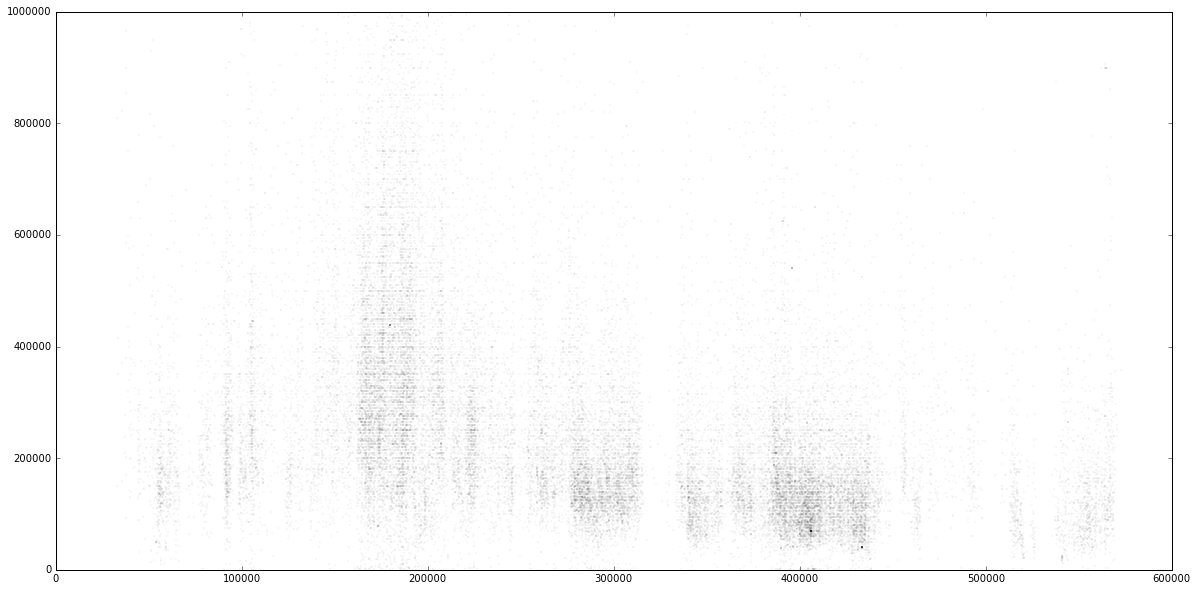

In [14]:
plt.figure(figsize=(20,10))
plt.plot(complete['northing'],complete['price'],'ko',markersize=1,alpha=0.05)
plt.ylim([0,1e6])


In [ ]:
for e,n,p in zip(complete['easting'],complete['northing'],complete['price']):
    plt.plot(e,n,'ok',markersize=p/1e5,alpha=0.4)

In [ ]:
len(complete)